In [53]:
import numpy as np
import pandas as pd
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.causal as csl
import pyagrum.causal.notebook as cslnb
import itertools
import networkx as nx
import matplotlib.pyplot as plt

Learned BN Structure:
BN{nodes: 9, arcs: 7, domainSize: 1152, dim: 21, mem: 304o}


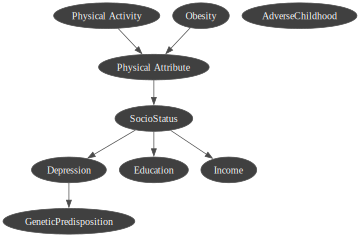

In [54]:
df = pd.read_csv("data_sample_1000.csv")
df = df.drop(['Traditional Methods', 'Artificial Intelligence'], axis=1)

# ----- Structure Learning -----
# When learning the structure, simply pass the dataframe to BNLearner.
bn = gum.BNLearner(df)

# Instruct the learner to use the MIIC algorithm.
bn.useMIIC() 

# Learn the structure of the BN.
bn_structure = bn.learnBN()
print("Learned BN Structure:")
print(bn_structure)

# Display the interactive graph of the learned Bayesian network
gnb.showBN(bn_structure)

Learned BN Structure:
BN{nodes: 9, arcs: 8, domainSize: 1152, dim: 22, mem: 328o}


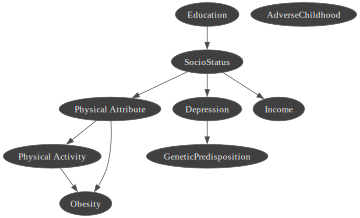

In [55]:
df = pd.read_csv("data_sample_1000.csv")
df = df.drop(['Traditional Methods', 'Artificial Intelligence'], axis=1)

# ----- Structure Learning -----
# When learning the structure, simply pass the dataframe to BNLearner.
bn = gum.BNLearner(df)

# Optionally choose the structure learning algorithm and scoring metric.
bn.useGreedyHillClimbing()  # Sets a local-search method.

# Learn the structure of the BN.
bn_structure = bn.learnBN()
print("Learned BN Structure:")
print(bn_structure)

# Display the interactive graph of the learned Bayesian network
gnb.showBN(bn_structure)